In [ ]:
import numpy as np
import random
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [77]:
class WrightFisher():
    """
    Haploid Wright-Fisher model
    
    Parameters:
    N: population size
    s: selection coefficient
    n: initial variant allele count
    """
    def __init__(self, N, s = 0, n = 1):
        # Set population size, selection coefficient and allele count for A
        self.N = N
        self.s = s
        self.n = n
        
        # Set initial allele frequencies
        self.p0 = self.n/self.N
        self.q0 = self.N - self.p0
        
        # Set fitnesses relative to selection
        self.wa = 1 + s
        self.wA = 1
        
    # Run Wright-Fisher simulation for a single site
    def simulateSingleSite(self, max_generations):
        # Create array of population alleles per generation
        population_alleles = np.zeros(max_generations + 1, dtype = int)
        # Set allele counts for initial generation
        population_alleles[0] = self.n
        
        # Initialise counters
        gen = 0
        allele_count = self.n
        max_allele_counts = self.n
        
        # Repeat for n generations
        while (gen < max_generations and 0 < allele_count < self.N + 1):
            gen += 1
            
            # Get the allele count in the previous generation
            allele_count = population_alleles[gen - 1]
            # Calculate probability of sampling the allele 
            prob = allele_count * (1 + self.s) / (allele_count * (1 + self.s) + self.N - allele_count)
            
            # Simulate number of copies in next generation
            population_alleles[gen] = np.random.binomial(n = self.N,
                                                         p = prob)
        
        return population_alleles
    
    # Run Wright-Fisher simulation for two loci
    def simulateTwoSites(self, alleles, allele_counts, singleton_haploid, r):
        # Whether one loci's allele is fixed
        allele_fixed = False

        # Set initial population
        current_alleles = alleles
        new_allele_counts = allele_counts
        
        # Record the haplotype frequencies per generation
        haplotype_frequencies = np.array(list(alleles.values()))

        # Record D', D and r^2 per generation
        ld_results = self.linkageDisequilibrium(alleles, allele_counts, singleton_haploid)
        D_normalised_per_gen = ld_results["D'"]
        D_per_gen = ld_results["D"]
        r2_per_gen = ld_results["r2"]
        
        # Get list of alleles, i.e. A, a, B, b
        allele_names = np.array(list(alleles.keys()))
        # Bias the probability of selection of each haplotype by the selection coefficient
        selection_coefficient_prob = np.array([-self.s, -self.s, -self.s, -self.s])

        # Get indexes of haplotypes to give add selection coefficient
        positive_haplotypes = [a for a in allele_names if singleton_haploid[0] in a]
        haplotype_indexes = np.concatenate((np.where(allele_names == positive_haplotypes[0]),
                                            np.where(allele_names == positive_haplotypes[1]))).flatten()
        # Set A allele from the singleton haploid to have positive selection 
        selection_coefficient_prob[haplotype_indexes] = self.s

        # Run simulation until one loci's allele is fixed
        while not allele_fixed:
            # Set new empty population
            new_alleles = {"AB": 0, "Ab": 0, "aB": 0, "ab": 0}

            # Populate the new population
            for i in range(self.N):

                # Probability of each haplotype being selected
                selection_probability = np.array(list(current_alleles.values())) / self.N
                
                # Add selection coefficient and normalise to add to 1
                selection_probability = selection_probability + selection_coefficient_prob
                selection_probability = (selection_probability - np.min(selection_probability)) / np.ptp(selection_probability)
                selection_probability = selection_probability / selection_probability.sum()

                # Randomly select a haplotype from the population
                individual = np.random.choice(list(current_alleles.keys()),
                                              p = selection_probability)

                # No recombination
                if np.random.uniform() > r:
                    # Offspring is the same as the individual in the next generation
                    new_alleles[individual] += 1

                # Make a recombinant haplotype
                else:
                    # Randomly select an allele to keep
                    allele_1 = np.random.choice(list(individual))

                    # If A loci, randomly select a B allele from the population
                    if allele_1.lower() == "a":
                        allele_2 = np.random.choice(["B", "b"],
                                                    p = np.array([new_allele_counts["B"],
                                                                  new_allele_counts["b"]]) / self.N)
                        # Form the new recombinant haplotype
                        offspring = allele_1 + allele_2

                    # Otherwise randomly select an A allele from the population
                    else:
                        allele_2 = np.random.choice(["A", "a"],
                                                    p = np.array([new_allele_counts["A"],
                                                                  new_allele_counts["a"]]) / self.N)
                        offspring = allele_2 + allele_1

                    # Add the recombinant offspring to the population
                    new_alleles[offspring] += 1

            # Update the new allele counts for the new population
            new_allele_counts = {"A": new_alleles["AB"] + new_alleles["Ab"],
                                 "a": new_alleles["aB"] + new_alleles["ab"],
                                 "B": new_alleles["AB"] + new_alleles["aB"],
                                 "b": new_alleles["Ab"] + new_alleles["ab"]}

            # Record D' and r^2
            ld_results = self.linkageDisequilibrium(new_alleles, new_allele_counts, singleton_haploid)
            D_normalised_per_gen = np.append(D_normalised_per_gen, ld_results["D'"])
            D_per_gen = np.append(D_per_gen, ld_results["D"])
            r2_per_gen = np.append(r2_per_gen, ld_results["r2"])
            
            # Record the haplotype frequency for the population
            haplotype_frequencies = np.vstack((haplotype_frequencies,
                                               np.array(list(new_alleles.values()))))

            # Check if any of the alleles have fixed
            if self.N in new_allele_counts.values():
                # Stop loop as an allele at a loci was lost
                allele_fixed = True
            else:
                # Set alleles for new population
                current_alleles = new_alleles
                
        return {"D'": D_normalised_per_gen, "D": D_per_gen, "r2": r2_per_gen,
                "haplotype_frequencies": np.transpose(haplotype_frequencies)}
        
    # Set population sizes for two loci simulation
    def initialiseTwoLoci(self, distribution):
        site_distribution = distribution[2:-2]
        
        # Population allele counts
        alleles = {"AB": 0, "Ab": 0, "aB": 0, "ab": 0}

        # Calculate probability of samples allele count between 2 to N - 2
        prob = site_distribution / sum(site_distribution)

        A_allele_count = np.random.choice(a = range(2, len(site_distribution) + 2), p = prob)
        a_allele_count = self.N - A_allele_count

        # Randomly introduce a singleton at a loci
        singleton_A = np.random.choice(["A", "a"])
        singleton_B = np.random.choice(["B", "b"])

        if singleton_B == "B":
            B_allele_count = 1
            b_allele_count = self.N - 1
        else:
            B_allele_count = self.N - 1
            b_allele_count = 1

        # Record the singleton
        alleles[singleton_A + singleton_B] = 1

        # Set the remaining allele counts
        if singleton_A + singleton_B == "AB":
            alleles["Ab"] = A_allele_count - 1
            alleles["aB"] = B_allele_count - alleles["AB"]
            alleles["ab"] = self.N - sum(alleles.values())

        elif singleton_A + singleton_B == "Ab":
            alleles["AB"] = A_allele_count - 1
            alleles["ab"] = b_allele_count - alleles["Ab"]
            alleles["aB"] = self.N - sum(alleles.values())

        elif singleton_A + singleton_B == "aB":
            alleles["AB"] = B_allele_count - 1
            alleles["Ab"] = A_allele_count - alleles["AB"]
            alleles["ab"] = self.N - sum(alleles.values())

        elif singleton_A + singleton_B == "ab":
            alleles["AB"] = A_allele_count
            alleles["Ab"] = b_allele_count - alleles["ab"]
            alleles["aB"] = self.N - sum(alleles.values())
            
        # Return the population genomes and allele frequencies
        return {"alleles": alleles,
                "allele_counts": {"A": A_allele_count,
                                  "a": a_allele_count,
                                  "B": B_allele_count,
                                  "b": b_allele_count},
                "singleton_haploid": singleton_A + singleton_B}
    
    # Calculate D' and r^2 LD statistics
    def linkageDisequilibrium (self, alleles, allele_counts, singleton_haploid):
        # Calculate proportion of individuals with an allele at each locus, i.e. pA, pa, pB, pb
        allele_probabilities = dict(zip(["p" + i for i in allele_counts.keys()],
                                        [allele_counts[j] / 100 for j in allele_counts.keys()]))
        # Proportion of two alleles occuring at the two loci, i.e. pAB, pAb, paB, pab
        haploid_probabilities = dict(zip(["p" + i for i in alleles.keys()],
                                         [alleles[j] / 100 for j in alleles.keys()]))

        # Calculate coefficient of linkage disequilibrium for each haplotype
        D_haplotype = {"AB": haploid_probabilities["pAB"] - (allele_probabilities["pA"] * allele_probabilities["pB"]),
                       "Ab": haploid_probabilities["pAb"] - (allele_probabilities["pA"] * allele_probabilities["pb"]),
                       "aB": haploid_probabilities["paB"] - (allele_probabilities["pa"] * allele_probabilities["pB"]),
                       "ab": haploid_probabilities["pab"] - (allele_probabilities["pa"] * allele_probabilities["pb"])}

        # Calculate normalised D by dividing by the maximum difference between observed and expected haplotype frequencies
        try:
            D_normalised = D_haplotype[singleton_haploid] / max(D_haplotype.values())
        except:
            # Prevent division by zero
            D_normalised = None

        # Calculate genetric correlation coefficient between pairs of loci
        try:
            r2 = (D_haplotype[singleton_haploid] ** 2) / (allele_probabilities["p" + singleton_haploid[0]] *
                                                          (1 - allele_probabilities["p" + singleton_haploid[0]]) *
                                                          allele_probabilities["p" + singleton_haploid[1]] *
                                                          (1 - allele_probabilities["p" + singleton_haploid[1]]))
        except:
            r2 = None
        
        return {"D'": D_normalised, "D": D_haplotype[singleton_haploid], "r2": r2}
    
    # Plot distribution of maximum allele count
    def plotMaxAllele(self, max_allele_counts,
                      title = "Distribution of Maximum Allele Number Reached ($\mathregular{M_i}$)"):
        max_allele_fig = plt.figure(figsize = (10, 5))
        max_allele_hist = plt.hist(max_allele_counts,
                                   color = "orange",
                                   edgecolor = "black", 
                                   linewidth = 1.2,
                                   bins = min(max(max_allele_counts), 100))
        plt.xlabel("Maximum Allele Number ($\mathregular{M_i}$)") 
        plt.ylabel("Number of Simulations") 
        plt.title(title)
        plt.show()
        
        return max_allele_fig
        
    # Plot distribution of time for simulations where the variant fixes or is lost
    def plotTime(self, fixation_times, loss_times, combine_plots = False,
                 title = "Distribution of Time Steps ($\mathregular{T_i}$) for the Allele to Fix or be Lost"):
        
        # Check whether to plot data on the same axis
        if combine_plots:
            time_hist_fig = plt.figure(figsize = (10, 5))
            # Plot fixation histogram
            plt.hist(fixation_times, color = "lime", label = "Fixed",
                     edgecolor = "black", linewidth = 1.2,
                     bins = 50, alpha = 0.5)
            # Also plot loss histogram on same axis
            plt.hist(loss_times, color = "red", label = "Lost",
                     edgecolor = "black", linewidth = 1.2,
                     bins = 50, alpha = 0.5)
            plt.xlabel("Time ($\mathregular{T_i}$)") 
            plt.ylabel("Number of Simulations")
            plt.title(title)
            plt.legend(loc = "upper right")
            
        # Otherwise create subplots
        else:
            time_hist_fig, axes = plt.subplots(1, 2, figsize = (12, 5))
            axes[0].hist(fixation_times, color = "lime", label = "Fixed",
                         edgecolor = "black", linewidth = 1.2,
                         bins = 50, alpha = 0.5)
            axes[1].hist(loss_times, color = "red", label = "Lost",
                         edgecolor = "black", linewidth = 1.2,
                         bins = 50, alpha = 0.5)
            axes[0].title.set_text("Fixation")
            axes[1].title.set_text("Loss")
            time_hist_fig.suptitle(title, y = 1.03)
            
            for ax in axes:
                ax.set_xlabel("Time ($\mathregular{T_i}$)")
                ax.set_ylabel("Number of Simulations")
            
        plt.show()
        
        return time_hist_fig
    
    # Plot density heatmap of allele counts over time
    def plotPathDensity(self, path_density, title = "Path Density", 
                        fontsize = 12, cmap = "viridis",
                        logscale = True, add_expected = False,
                        expected_colour = "white"):
        
        # Create figure
        density_fig, ax = plt.subplots(figsize = (11, 9))
        # Log the data if logscale set as True
        density_data = np.log(path_density + 1) if logscale else path_density
        
        # Add density heatmap of allele counts over time
        heatmap = ax.imshow(density_data, cmap = cmap, aspect = "auto")
        
        # Flip the y-axis so n increases upwards
        ax.set_ylim(ax.get_ylim()[::-1])
        
        # Add colour bar
        colour_bar = density_fig.colorbar(heatmap, pad = 0.15 if add_expected else 0.05)
        colour_bar_label = "Log(Density + 1)" if logscale else "Density"
        colour_bar.ax.set_title(colour_bar_label, fontsize = 10)

        if add_expected:
            # Create sigmoid expectation curve for p(t) under the deterministic, no drift model
            t = np.linspace(0, len(simulation_results["path_density"][0]) - 1,
                            num = len(simulation_results["path_density"][0]))
            n = 1/(1 + ((self.q0/self.p0) * ((self.wA / self.wa) ** t)))
            
            # Plot curve on top
            ax2 = plt.twinx()
            sns.lineplot(x = t, y = n, linewidth = 3, ax = ax2, color = expected_colour)
            ax.axis('tight')
            ax2.set_ylabel("Expected p(t) with no Drift", fontsize = fontsize)
        
        ax.set_xlabel("Time (t)", fontsize = fontsize)
        ax.set_ylabel("Allele Count (n)", fontsize = fontsize)
        ax.set_title(title, fontsize = fontsize + 2)
        plt.show()
        
        return density_fig
        
    # Plot distribution of number of copies of an allele over all generations
    def plotAlleleCount(self, all_allele_counts, logscale = True,
                        title = "Distribution of Total Allele Copies Across Generations S(n)"):
        allele_counts_fig = plt.figure(figsize = (10, 5))
        allele_counts_bar = plt.bar(range(len(all_allele_counts)),
                                    all_allele_counts,
                                    color = "skyblue",
                                    edgecolor = "black", 
                                    linewidth = 1.2)
        plt.xlabel("Allele Count (n)") 
        plt.ylabel("Frequency")
        plt.title(title)
        plt.yscale("log" if logscale else "linear")
        plt.show()
        
        return allele_counts_fig
    
    # Run the single site simulator n times
    def repeatSimulateSingle(self, max_generations = 500, n_times = 1000):
        # The highest numbers the allele reaches per simulation
        max_allele_counts = np.zeros(n_times, dtype = int)
        # The times taken for the allele to fix or be lost
        end_times = np.zeros(n_times, dtype = int)
        # Density of allele counts over time for n simulations
        path_density = np.zeros((self.N + 1, max_generations), dtype = int)
        
        # Total time for simulations that fix and loose the allele
        fixation_times = np.array([])
        loss_times = np.array([])
        fluctuating_times = np.array([])
        # Average time for simulations that fix and loose the allele
        mean_fixation_time = None
        mean_loss_time = None
        
        # Run the simulation n times
        for i in range(n_times):
            # Run Wright-Fisher model
            population_alleles = self.simulateSingleSite(max_generations)
            # Get the maximum allele count and simulation end time
            max_allele_counts[i] = max(population_alleles)
            end_times[i] = len(population_alleles[population_alleles != 0])
            
            # Increment path density for the new allele counts over time
            for j in range(1, len(population_alleles)):
                path_density[population_alleles[j]][j - 1] += 1
                
            # Check if allele fixes
            if population_alleles[-1] == self.N:
                # Add time when allele fixes
                fixation_times = np.append(fixation_times,
                                           np.where(population_alleles == self.N)[0][0])
            elif population_alleles[-1] == 0:
                # Add time taken for allele to be lost
                loss_times = np.append(loss_times, end_times[i])
                
        # Number of simulations in which the allele fixes, is lost or still fluctuating
        n_fixed = len(fixation_times)
        n_lost = len(loss_times)
        n_fluctuating = n_times - n_fixed - n_lost
        
        # Calculate average fixation and loss time
        if n_fixed > 0:
            mean_fixation_time = sum(fixation_times) / len(fixation_times)
        if n_lost > 0:
            mean_loss_time = sum(loss_times) / len(loss_times)
            
        # S(n) distribution, i.e. number of copies of the variant alelle over all generations
        all_allele_counts = np.array([sum(row) for row in path_density])
        
        return {"max_allele_counts": max_allele_counts,
                "end_times": end_times,
                "path_density": path_density,
                "n_fixed": n_fixed,
                "n_lost": n_lost,
                "n_fluctuating": n_fluctuating,
                "mean_fixation_time": mean_fixation_time,
                "mean_loss_time": mean_loss_time,
                "fixation_times": fixation_times,
                "loss_times": loss_times,
                "all_allele_counts": all_allele_counts}

In [ ]:
# Set selection coefficient s
selection_coefficient = 0.005

# Run the simulator
wf_simulator = WrightFisher(N = 100, s = selection_coefficient)
simulation_results = wf_simulator.repeatSimulateSingle(n_times = 1000)

# Print summary statistics
print("Fixed " + str(simulation_results["n_fixed"]) + " times")
print("Lost " + str(simulation_results["n_lost"]) + " times")
print("Fluctuating " + str(simulation_results["n_fluctuating"]) + " times")
if simulation_results["mean_fixation_time"] != None:
    print("Average fixation time of " + str(round(simulation_results["mean_fixation_time"], 3)))
print("Average loss time of " + str(round(simulation_results["mean_loss_time"], 3)))

# Add s to plot titles and file names if s not zero
extra_title = " for s = " + str(selection_coefficient) if selection_coefficient != 0 else ""
extra_file_name = "_s=" + str(selection_coefficient) if selection_coefficient != 0 else ""

# Plot results
allele_count_bar = wf_simulator.plotAlleleCount(simulation_results["all_allele_counts"], logscale = True,
                                               title = "Distribution of Total Allele Copies Across Generations S(n)" + extra_title)
time_bars = wf_simulator.plotTime(simulation_results["fixation_times"], simulation_results["loss_times"],
                                 title = "Distribution of Time Steps ($\mathregular{T_i}$) for the Allele to Fix or be Lost" + extra_title)
max_allele_hist = wf_simulator.plotMaxAllele(simulation_results["max_allele_counts"],
                                            title = "Distribution of Maximum Allele Number Reached ($\mathregular{M_i}$)" + extra_title)
density_plot = wf_simulator.plotPathDensity(simulation_results["path_density"], 
                                            cmap = "Spectral", logscale = True,
                                            title = "Path Density for 1000 Simulations" + extra_title,
                                            add_expected = True if selection_coefficient != 0 else False)

# Save plots
allele_count_bar.savefig("Allele_Count_Bar" + extra_file_name + ".pdf", bbox_inches = "tight")
time_bars.savefig("Time_Bars" + extra_file_name + ".pdf", bbox_inches = "tight")
max_allele_hist.savefig("Max_Allele_Histogram" + extra_file_name + ".pdf", bbox_inches = "tight")
density_plot.savefig("Path_Density" + extra_file_name + ".pdf", bbox_inches = "tight")

In [4]:
# Set new selection coefficient and recombination rate
selection_coefficient = 0.005
recombination_rate = 0.05

# Create a new simulator
wf_simulator2 = WrightFisher(N = 100, s = selection_coefficient)

In [11]:
# Set number of times to test initial distribution of D' and r^2
n_initial = 1

# Record D' and r^2 for n initial populations
initial_ld_d_norm = np.zeros(n_initial)
initial_ld_r2 = np.zeros(n_initial)

for i in range(n_initial):
    # Set initial haplotype sizes, number of AB, Ab, aB, ab
    simulation_results2 = wf_simulator.repeatSimulateSingle(n_times = 1000)
    initial_loci = wf_simulator2.initialiseTwoLoci(simulation_results2["all_allele_counts"])

    # Get allele counts and which haplotype has a count of 1
    initial_alleles = initial_loci["alleles"]
    initial_allele_counts = initial_loci["allele_counts"]
    singleton = initial_loci["singleton_haploid"]

    # Record LD measures
    ld_results = wf_simulator2.linkageDisequilibrium(initial_alleles, initial_allele_counts, singleton)
    initial_ld_d_norm[i] = ld_results["D'"]
    initial_ld_r2[i] = ld_results["r2"]
    
# Set lists of haplotypes and alleles
all_haplotypes = list(initial_alleles.keys())
all_alleles = list(initial_allele_counts.keys())
    
print("Initial alleles: " + str(initial_alleles))
print("Initial allele count: " + str(initial_allele_counts))
print("Singleton allele: " + str(singleton))

Initial alleles: {'AB': 1, 'Ab': 15, 'aB': 0, 'ab': 84}
Initial allele count: {'A': 16, 'a': 84, 'B': 1, 'b': 99}
Singleton allele: AB


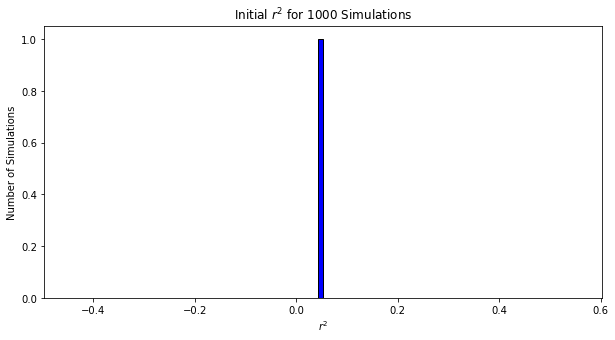

In [12]:
def plotRSquared(r2_values):
    # Plot histogram of r^2 per simulation
    fig = plt.figure(figsize = (10, 5))
    plt.hist(r2_values, color = "blue", edgecolor = "black", bins = 100)
    plt.title("Initial $r^{2}$ for 1000 Simulations")
    plt.xlabel("$r^{2}$")
    plt.ylabel("Number of Simulations")
    
    return fig

# Plot initial distribution of r^2
r2_histogram = plotRSquared(initial_ld_r2)

# Save plot
r2_histogram.savefig("r2_Initial_Distribution.pdf", bbox_inches = "tight")

In [13]:
# Calculate the average value across time steps for LD or haplotype frequencies
def averageResults(results):
    
    # Determine the shape of the results array
    size = "2D" if len(results[0].shape) == 1 else "3D"
    
    if size == "2D":
        # Get the longest time the simulation lasted
        max_time = max([len(x) for x in results])
        # Pad the results arrays with None to be the same size
        results = [np.pad(results[x], (0, max_time - len(results[x])),
                          constant_values = None) for x in range(len(results))]
        
    else:
        # Get the longest time the simulation lasted
        max_time = max([x.shape[1] for x in results])
        # Pad the results arrays with NaN to be the same size
        results = [np.pad(np.array(results[x], dtype = "object"),
                          [(0, 0), (0, max_time - results[x].shape[1])],
                          mode = 'constant', constant_values = float("nan"))
                   for x in range(len(results))]

    # Record average haplotype frequency, r^2, D' or D
    mean_results = np.array([])

    # Calculate the average haplotype frequency per time step
    for y in range(max_time):
        time_step_results = np.array([np.transpose(results[x])[y] for x in range(len(results))])
        
        if size == "2D":
            # Remove None or NaN values
            time_step_results = [x for x in time_step_results if x != None and not math.isnan(x)]
            # Record average
            mean_results = np.append(mean_results, np.mean(time_step_results, axis = 0))
        
        else:
            # Record average across 3D arrays, ignoring placeholder NaNs
            mean_values = np.nanmean(np.array([np.transpose(results[x])[y]
                                            for x in range(len(results))]), axis = 0)
            if y == 0:
                mean_results = mean_values
            else:
                mean_results = np.vstack((mean_results, mean_values))
        
    return mean_results

In [50]:
def testParameters(alleles, allele_counts, singleton_haploid, 
                   r = [0.01], s = [0], N = 100, n_simulations = 1000):
    
    r = np.array(r)
    s = np.array(s)
    
    # Determine whether to test recombination rates or selection coefficients
    if len(r) > 1:
        test_type = "recombination"
        rates = r
    else:
        test_type = "selection"
        rates = s
    
    # Create new Wright Fisher simulator
    simulator = WrightFisher(N = N, s = s[0])
    
    # Record results for each recombination rate / selection coefficient for each iteration
    all_results = dict(zip(rates, [np.array([]) for i in range(len(rates))]))

    # Record haplotype frequencies and LD measures
    average_haplotype_freq = {}
    average_r2 = {}
    average_D = {}
    average_D_norm = {}
    
    r_value = r[0]
    s_value = s[0]

    # Test each recombination rate / selection coefficient
    for i in range(len(rates)):
        
        if test_type == "recombination":
            # Set recombination rate
            r_value = r[i]
            test_value = r_value
        else:
            # Set selection coefficient
            s_value = s[i]
            simulator.s = s_value
            test_value = s_value

        # Run the simulation n times
        for j in range(n_simulations):
            two_loci_simulation_results = simulator.simulateTwoSites(alleles,
                                                                     allele_counts,
                                                                     singleton_haploid,
                                                                     r = r_value)
            # Record the results per simulation
            all_results[test_value] = np.append(all_results[test_value],
                                                two_loci_simulation_results)

        # Get the haplotype frequencies for the recombination rate
        average_haplotype_freq[test_value] = averageResults([res["haplotype_frequencies"] for res in all_results[test_value]])
        average_r2[test_value] = averageResults([res["r2"] for res in all_results[test_value]][:-1])
        average_D[test_value] = averageResults([res["D"] for res in all_results[test_value]][:-1])
        average_D_norm[test_value] = averageResults([res["D'"] for res in all_results[test_value]][:-1])
        
    return {"results_per_simulation": all_results,
            "average_haplotype_freq": average_haplotype_freq,
            "average_r2": average_r2,
            "average_D": average_D,
            "average_D_norm": average_D_norm}

In [ ]:
# Recombination rates and selection coefficients to test
test_r = [0.01, 0.02, 0.05]
test_s = [0.02, 0.005, -0.005, -0.02]
    
# # Test different recombination rates
# recombination_results = testParameters(initial_alleles,
#                                        initial_allele_counts,
#                                        singleton,
#                                        r = test_r,
#                                        s = [0],
#                                        n_simulations = 1000)

# Test different selection coefficients
selection_results = testParameters(initial_alleles,
                                   initial_allele_counts,
                                   singleton,
                                   r = [0.01],
                                   s = test_s,
                                   n_simulations = 1000)

In [ ]:
# Plot D, D' and r^2 over all simulations and the average
def plotLinkageDisequilibrium(colours, linestyles, all_results, r = [0.01], s = [0]):
    
    r = np.array(r)
    s = np.array(s)
    
    # Determine whether to plot recombination rates or selection coefficients
    if len(r) > 1:
        test_type = "recombination"
        rates = r
    else:
        test_type = "selection"
        rates = s
        
    # Determine the number of simulations
    n_simulations = len(all_results["results_per_simulation"][rates[0]])

    # Create subplots of LD over time for the recombination rates
    ld_fig, axes = plt.subplots(3, 2, figsize = (15, 10), sharex = True)
    ld_fig.suptitle("Linkage Disequilibrium over Time for " + str(n_simulations) + " Simulations",
                      fontsize = 13, y = 0.95)

    # Iterate through recombination rates / selection coefficients
    for value in rates:
        # Get LD results
        results_per_simulation = all_results["results_per_simulation"][value]
        average_r2 = all_results["average_r2"][value]
        average_D = all_results["average_D"][value]
        average_D_norm = all_results["average_D_norm"][value]

        # Overlay D, D' and r^2 results for each simulation by adding transparent lines
        for n in range(n_simulations):
            axes[0,0].plot(results_per_simulation[n]["D"],
                           color = colours[value],
                           linestyle = linestyles[value],
                           alpha = 0.3)
            axes[1,0].plot(results_per_simulation[n]["D'"],
                           color = colours[value],
                           linestyle = linestyles[value],
                           alpha = 0.3)
            axes[2,0].plot(results_per_simulation[n]["r2"],
                           color = colours[value],
                           linestyle = linestyles[value],
                           alpha = 0.3)

        # Plot average D, D' and r^2 for recombination rate / selection coefficient
        axes[0,1].plot(average_D, color = colours[value],
                       linestyle = linestyles[value], label = value)
        axes[1,1].plot(average_D_norm, color = colours[value],
                       linestyle = linestyles[value])
        axes[2,1].plot(average_r2, color = colours[value],
                       linestyle = linestyles[value])

    # Set axis labels and titles
    axes[0,0].set_ylabel("Coefficient of LD (D)")
    axes[1,0].set_ylabel("Normalised coefficient of LD (D')")
    axes[2,0].set_ylabel("Genetic Correlation ($r^{2}$)")
    axes[2,0].set_xlabel("Time (t)")
    axes[2,1].set_xlabel("Time (t)")
    axes[0,0].set_title("All Results")
    axes[0,1].set_title("Average")

    # Position legend and show plot
    ld_fig.legend(loc = "upper right", bbox_to_anchor = (1, 0.88),
                  title = "Recombination\nRate (r)\n" if test_type == "recombination"
                  else "Selection\nCoefficient (s)\n")
    plt.show()
    
    return ld_fig

# Set plot styles for values to test
r_colours = {0.01: "yellowgreen", 0.02: "aqua", 0.05: "indigo"}
s_colours = {0.02: "lightblue", 0.005: "orange", -0.005: "fuchsia", -0.02: "navy"}
r_linestyles = {0.05: "solid", 0.01: "solid", 0.02: "solid"}
s_linestyles = {0.02: "solid", 0.005: "solid", -0.005: "solid", -0.02: "solid"}

# Plot LD measures
r_ld_fig = plotLinkageDisequilibrium(r_colours, r_linestyles, recombination_results, r = test_r)
s_ld_fig = plotLinkageDisequilibrium(s_colours, s_linestyles, selection_results, s = test_s)

r_ld_fig.savefig("LD_Over_Time_Recombination_Rates.pdf", bbox_inches = "tight")
s_ld_fig.savefig("LD_Over_Time_Selection_Coefficients.pdf", bbox_inches = "tight")

In [ ]:
def plotHaplotypeFrequency(colours, all_results, haplotype_names, r = [0.01], s = [0]):
    
    r = np.array(r)
    s = np.array(s)
    
    # Determine whether to plot recombination rates or selection coefficients
    if len(r) > 1:
        test_type = "recombination"
        rates = r
    else:
        test_type = "selection"
        rates = s
    
    # Determine the number of simulations
    n_simulations = len(all_results["results_per_simulation"][rates[0]])
    
    # Plot haplotype frequency for the recombination rates
    haplotype_fig, axes = plt.subplots(len(rates), 2, figsize = (15, 10), sharex = True)
    haplotype_fig.suptitle("Haplotype Frequency over Time for " + str(n_simulations) + " Simulations",
                 fontsize = 13, y = 0.95)

    # Add plot for each recombination rate
    for i in range(len(rates)):
        value = rates[i]
        
        results_per_simulation = all_results["results_per_simulation"][value]
        average_haplotype_freq = all_results["average_haplotype_freq"][value]

        # Overlay results for each simulation by adding transparent lines
        for n in range(n_simulations):
            for j in range(len(haplotype_names)):
                haplotype = haplotype_names[j]
                axes[i,0].plot(results_per_simulation[n]["haplotype_frequencies"][j],
                               color = colours[haplotype], alpha = 0.3)

        # Plot average per haplotype
        for k in range(len(haplotype_names)):
            haplotype = haplotype_names[k]
            haplotype_freq = np.transpose(average_haplotype_freq)[k]
            axes[i,1].plot(haplotype_freq, color = colours[haplotype],
                           label = haplotype if i == 1 else "")
            
        # Set y-axis labels
        axes[i,0].set_ylabel(test_type[0] + " = " + str(rates[i]))

    # Set x-axis labels and titles
    axes[2,0].set_xlabel("Time (t)")
    axes[2,1].set_xlabel("Time (t)")
    axes[0,0].set_title("All Results")
    axes[0,1].set_title("Average")

    # Position legend and show plot
    haplotype_fig.legend(loc = "upper right", bbox_to_anchor = (0.98, 0.88), title = "Haplotype")
    plt.show()
    
    return haplotype_fig

# Set plot colours
r_haplotype_colours = {"AB": "blue", "Ab": "orange", "aB": "green", "ab": "red"}
s_haplotype_colours = {"AB": "orangered", "Ab": "orchid", "aB": "gold", "ab": "chartreuse"}

# Plot haplotype frequency over time for different r and s values
r_haplotype_fig = plotHaplotypeFrequency(r_haplotype_colours, recombination_results, all_haplotypes, test_r)
s_haplotype_fig = plotHaplotypeFrequency(s_haplotype_colours, selection_results, all_haplotypes, test_s)

# Save the plots
r_haplotype_fig.savefig("Haplotypes_Over_Time_Recombination_Rates.pdf", bbox_inches = "tight")
s_haplotype_fig.savefig("Haplotypes_Over_Time_Selection_Coefficients.pdf", bbox_inches = "tight")

In [ ]:
# Record the haplotypes and allele frequencies for the last generation in each simulation
final_haplotypes = dict(zip(test_s, [np.array([]) for i in range(len(test_s))]))
final_allele_counts = dict(zip(test_s, [{} for i in range(len(test_s))]))

# Iterate over s values
for i in range(len(test_s)):
    s_value = test_s[i]
    
    # Get frequencies per simulation
    for n in range(len(selection_results["results_per_simulation"][s_value])):
        # Find the haplotype frequencies at the final generation
        final_haplotype_freq = selection_results["results_per_simulation"][s_value][n]["haplotype_frequencies"][:, -1]
        # Record the final frequencies
        if n == 0:
            final_haplotypes[s_value] = final_haplotype_freq
        else:
            final_haplotypes[s_value] = np.vstack((final_haplotypes[s_value],final_haplotype_freq))
            
    # Calculate allele counts
    final_allele_counts[s_value]["A"] = final_haplotypes[s_value][:, 0] + final_haplotypes[s_value][:, 1]
    final_allele_counts[s_value]["a"] = final_haplotypes[s_value][:, 2] + final_haplotypes[s_value][:, 3]
    final_allele_counts[s_value]["B"] = final_haplotypes[s_value][:, 0] + final_haplotypes[s_value][:, 2]
    final_allele_counts[s_value]["b"] = final_haplotypes[s_value][:, 1] + final_haplotypes[s_value][:, 3]
    
    # Calculate mean of each allele
    allele_means = [np.mean(a) for a in list(final_allele_counts[s_value].values())]
    
    if i == 0:
        allele_mean_data = allele_means
    else:
        allele_mean_data = np.vstack((allele_mean_data, [np.mean(a) for a in list(final_allele_counts[s_value].values())]))
        
# Create dataframe for plotting
allele_mean_df = pd.DataFrame(np.transpose(np.vstack((list(final_allele_counts[s_value].keys()),
                                                      allele_mean_data))),
                              columns = ["Allele"] + test_s)
# Convert mean allele columns to numeric
allele_mean_df[test_s] = allele_mean_df[test_s].apply(pd.to_numeric)

# View the data
print(allele_mean_df)

# Plot grouped bar chart
allele_mean_fig = allele_mean_df.plot(x = "Allele", kind = "bar", stacked = False,
                                      logy = True, title = "Mean Allele Frequencies",
                                      color = list(s_colours.values()),
                                      figsize = (10, 5))
allele_mean_fig.legend(loc = "upper right", bbox_to_anchor = (1.33, 0.9),
                       title = "Selection\nCoefficient (s)")
plt.show()

# Save the plot
allele_mean_fig.get_figure().savefig("Mean_Allele_Frequencies_Selection_Coefficients.pdf",
                                     bbox_inches = "tight")

Extra plots

In [ ]:
fig, axes = plt.subplots(4, 1, figsize = (15, 10), sharex = True)
fig.suptitle("Allele Frequency over Time for " + str(len(final_allele_counts[s_value][all_alleles[0]])) + " Simulations",
             fontsize = 13, y = 0.95)

for i in range(len(final_haplotypes.keys())):
    s = list(final_allele_counts.keys())[i]
    for j in range(4):
        allele = all_alleles[j]
        axes[i].hist(final_allele_counts[s][allele], label = allele if i == 0 else "",
                             bins = 100, alpha = 0.5)
        
    # Set y-axis
    axes[i].set_ylabel("s = " + str(s))
    axes[i].set_yscale("log")

# Position legend and show plot
fig.legend(loc = "upper right", bbox_to_anchor = (0.98, 0.88), title = "Haplotype")
plt.show()

In [ ]:
fig, axes = plt.subplots(4, 1, figsize = (15, 10), sharex = True)
fig.suptitle("Haplotype Frequency over Time for Simulations",
             fontsize = 13, y = 0.95)

for i in range(len(final_haplotypes.keys())):
    s = list(final_haplotypes.keys())[i]
    for j in range(4):
        haplotype = all_haplotypes[j]
        axes[i].hist(final_haplotypes[s][:, j], label = haplotype if i == 0 else "",
                             bins = 100, alpha = 0.5)
        
    # Set y-axis
    axes[i].set_ylabel("s = " + str(s))
    axes[i].set_yscale("log")

# Position legend and show plot
fig.legend(loc = "upper right", bbox_to_anchor = (0.98, 0.88), title = "Haplotype")
plt.show()